<h2>Problem Statement : 

Make a Smart Home Assistant, similar to Alexa, which will be capable of turning on and off lights based on the voice commands given by the user. This will be handled by an LLM gathering voice inputs, and using langgraph to ensure the network structure of the house.
<br>#PART 1 : "What should I wear today?"


<br>#PART 2 : Full Smart home


</h2>

<h3>Python playbook

<h4> 1. Figuring out how to make speech-to-text work

In [ ]:
# Python program to translate
# speech to text and text to speech


import speech_recognition as sr
import pyttsx3 

# Initialize the recognizer 
r = sr.Recognizer() 

# Function to convert text to speech
def SpeakText(command):
    
    # Initialize the engine
    engine = pyttsx3.init()
    engine.say(command) 
    engine.runAndWait()
    
    
# Loop infinitely for user to speak

while(1):    
    try:
        
        # use the microphone as source for input.
        with sr.Microphone() as source2:
            
            # wait for a second to let the recognizer adjust the energy threshold based on the surrounding noise level 
            r.adjust_for_ambient_noise(source2, duration=0.2)
            
            #listens for the user's input 
            audio2 = r.listen(source2)
            
            # Using google to recognize audio
            MyText = r.recognize_google(audio2)
            MyText = MyText.lower()

            print("Did you say ", MyText)
            SpeakText(MyText)
            
    except sr.RequestError as e:
        print("Could not request results; {0}".format(e))
        
    except sr.UnknownValueError:
        print("unknown error occurred")


<h4>2. That was surprisingly quick. Now lets make an agent. </h4>
<p>The main thing I want to do right now is build a really simple agent, which only has the "Start", "Agent" and "Output" state. The Agent will take in the user's input as speech, and give its own response in an audio output

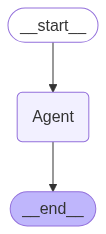

In [5]:
from typing import TypedDict, List
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage
from langgraph.graph import START, END, StateGraph

class AgentState(TypedDict):
    messages: List[HumanMessage]

llm = ChatOllama(model="qwen2.5:0.5b")

def process_node(state: AgentState) -> AgentState:
    """This node simply sends the user input as a human message to chat ollama llm, and prints its response without recording it in the state"""
    response = llm.invoke(state["messages"])
    print("\nAI: " + response.content)
    return state

graph = StateGraph(AgentState)
graph.add_node("Agent", process_node)
graph.add_edge(START, "Agent")
graph.add_edge("Agent", END)

app = graph.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
conversation_history = []

def get_voice_input():
    try:
        
        # use the microphone as source for input.
        with sr.Microphone() as source2:
            
            # wait for a second to let the recognizer adjust the energy threshold based on the surrounding noise level 
            r.adjust_for_ambient_noise(source2, duration=0.2)
            
            #listens for the user's input 
            audio2 = r.listen(source2)
            
            # Using google to recognize audio
            user_input = r.recognize_google(audio2)
            user_input = user_input.lower()
            
    except sr.RequestError as e:
        print("Could not request results; {0}".format(e))
        
    except sr.UnknownValueError:
        print("unknown error occurred")

    return user_input

command =  get_voice_input()

while command != 'exit game':
     
        print("Human: ", command)
        conversation_history.append(HumanMessage(content=command))
        AiResponse = app.invoke({"messages": conversation_history})
        conversation_history = AiResponse["messages"]
        #SpeakText(AiResponse)
        command = get_voice_input()